Steps:

- Load data and visualize a sample of them
- Check for distribution across classes

- Give ERM/IRM a shot to improve the performance

In [1]:
# Run following commands if running on local
# !pip install kaggle

# Download kaggle.json from kaggle website under profile->new API section
# !kaggle competitions download -c plant-seedlings-classification
# !unzip -q plant-seedlings-classification.zip

In [2]:
from torch.utils.data import Dataset
import os, glob
from PIL import Image

class ImgDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.imgs = glob.glob(os.path.join(root, '*.png'))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        if self.transform:
            img = self.transform(img)
        return img, 1

In [3]:
os.chdir('/kaggle/input/plant-seedlings-classification/')

In [4]:
# Folder structure
# Training data
# contains images in 12 folders, each folder contains images of a single class
# Test data
# contains all images in a single folder

# Load the data
from torchvision import datasets, transforms

transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('./train', transform=transforms)
testDataset = ImgDataset('./test', transform=transforms)

### Class Distribution

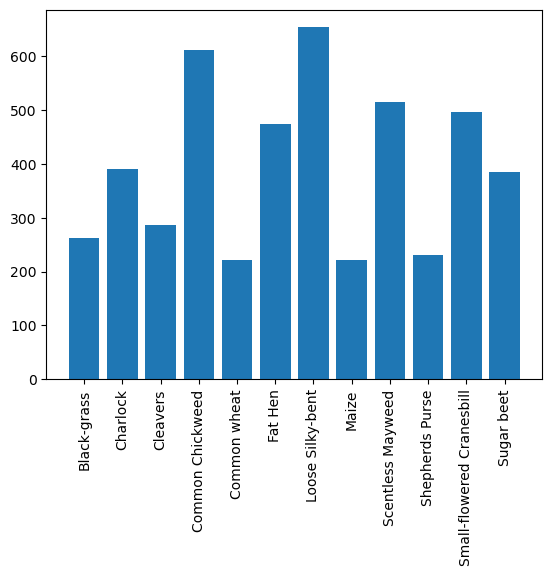

In [5]:
# Plot class distribution
from collections import Counter
import matplotlib.pyplot as plt

distribution = dict(Counter(dataset.targets))

# Plot class distribution histogram
plt.bar(list(map(lambda x: dataset.classes[x], distribution.keys())), distribution.values())
plt.xticks(rotation=90)
plt.show()

### Sampling imbalance classes

In [6]:
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

def sampler(indices):
    labels = [dataset.targets[x] for x in indices]
    print(f'label length: {len(labels)}')
    distribution = dict(Counter(labels))
    class_weights = {k: 1/v for k, v in distribution.items()}

    samples_weight = np.array([class_weights[t] for t in labels])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [7]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

# Split validation data from training data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices) # shuffle the dataset before splitting into train and val
print(f'dataset_size: {dataset_size}')

split = int(np.floor(0.8 * dataset_size))
train_indices, val_indices = indices[:split], indices[split:]

BATCH_SIZE = 64

train = DataLoader(Subset(dataset, train_indices), sampler=sampler(train_indices), batch_size=BATCH_SIZE)
val = DataLoader(Subset(dataset, val_indices), sampler=sampler(val_indices), batch_size=BATCH_SIZE)
test = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

dataset_size: 4750
label length: 3800
label length: 950


### Visualize distribution after sampling

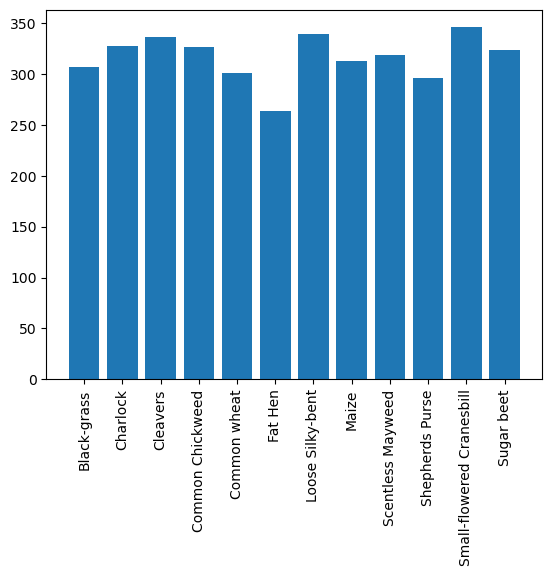

In [10]:
# Plot class distribution histogram for training data
class_counts = [0]*len(dataset.classes)

for i, (_, label) in enumerate(train):
    for l in label:
        class_counts[l] += 1

# Plot class distribution histogram
plt.bar(dataset.classes, class_counts)
plt.xticks(rotation=90)
plt.show()

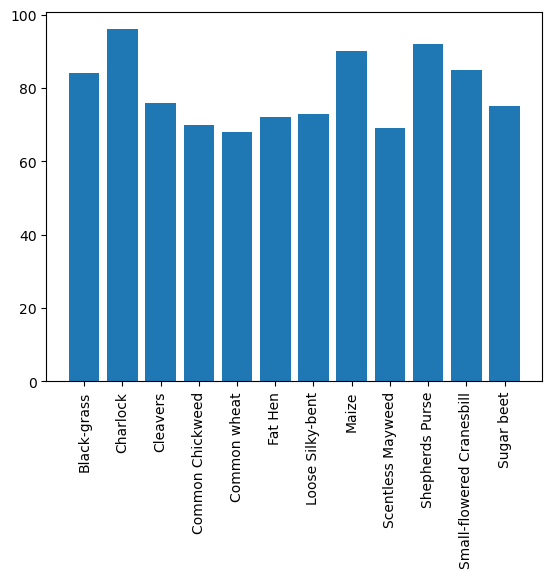

In [11]:
# Plot class distribution histogram for validation data
class_counts = [0]*len(dataset.classes)

for i, (_, label) in enumerate(val):
    for l in label:
        class_counts[l] += 1

# Plot class distribution histogram
plt.bar(dataset.classes, class_counts)
plt.xticks(rotation=90)
plt.show()

### Visualize images

In [12]:
def visualizeBatch(batch, classes=None):
    # sample 8 indexes from BATCH_SIZE
    indexes = np.random.choice(BATCH_SIZE, 8, replace=False)
    for i, j in enumerate(indexes):
        image, idx = batch[0][j], batch[1][j]
        
        ax = plt.subplot(2, 4, i + 1)
        image = image.cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (255.0 * image).astype('uint8')
        
        plt.imshow(image)
        if classes is not None:
            plt.title(classes[idx])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

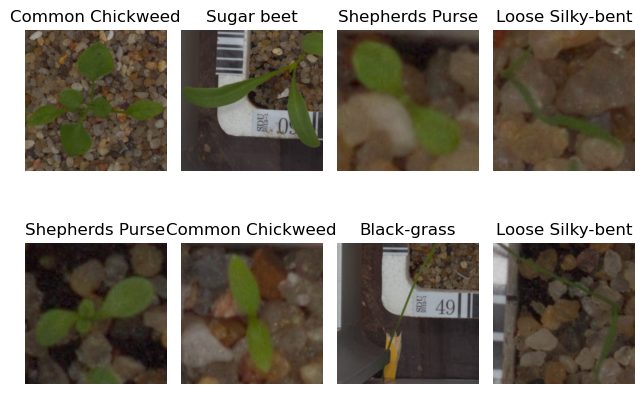

In [13]:
trainBatch = next(iter(train))
visualizeBatch(trainBatch, dataset.classes)

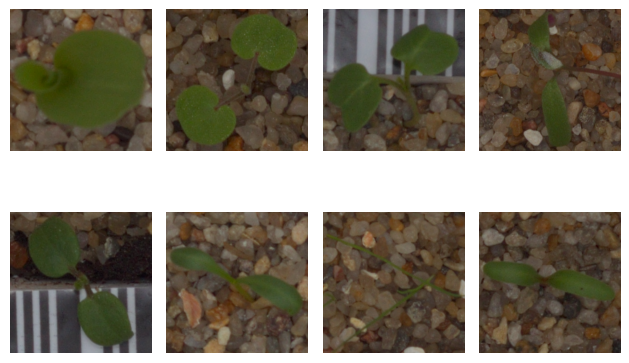

In [14]:
testBatch = next(iter(test))
visualizeBatch(testBatch)

### FineTuning resnet-50

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from transformers import AutoImageProcessor, ResNetForImageClassification

# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50").to(device)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [14]:
# define trainingloop
def train_loop(model, train, val, optimizer, loss_fn, epochs=10):
    for epoch in range(epochs):
        model.train()
        for i, (image, label) in enumerate(train):
#             image = processor(image, return_tensors="pt").to(device)
            image = image.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            output = model(image, labels=label)
            loss = output.loss
            loss.backward()
            optimizer.step()
            
            if i % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {i}, Training Loss: {loss.item()}')
        
        model.eval()
        with torch.no_grad():
            for i, (image, label) in enumerate(val):
#                 image = processor(image, return_tensors="pt").to(device)
                image = image.to(device)
                label = label.to(device)
                
                output = model(image, labels=label)
                loss = output.loss
                
                if i % 10 == 0:
                    print(f'Epoch: {epoch}, Batch: {i}, Validation Loss: {loss.item()}')
    
    return model

In [11]:
epoch = 10
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
criteria = torch.nn.CrossEntropyLoss()

In [12]:
model = train_loop(model, train, val, optimizer, criteria, epochs=epoch)

Epoch: 0, Batch: 0, Loss: 8.205154418945312
Epoch: 0, Batch: 10, Loss: 8.20725154876709
Epoch: 0, Batch: 20, Loss: 8.194703102111816
Epoch: 0, Batch: 30, Loss: 8.396211624145508
Epoch: 0, Batch: 40, Loss: 8.271594047546387
Epoch: 0, Batch: 50, Loss: 8.577884674072266
Epoch: 0, Batch: 0, Loss: 8.533305168151855
Epoch: 0, Batch: 10, Loss: 8.895505905151367
Epoch: 1, Batch: 0, Loss: 8.269206047058105
Epoch: 1, Batch: 10, Loss: 8.01345157623291
Epoch: 1, Batch: 20, Loss: 8.270890235900879
Epoch: 1, Batch: 30, Loss: 8.404516220092773
Epoch: 1, Batch: 40, Loss: 8.18336296081543
Epoch: 1, Batch: 50, Loss: 7.969113826751709
Epoch: 1, Batch: 0, Loss: 7.93293571472168
Epoch: 1, Batch: 10, Loss: 8.01025676727295
Epoch: 2, Batch: 0, Loss: 7.894320487976074
Epoch: 2, Batch: 10, Loss: 7.969165325164795
Epoch: 2, Batch: 20, Loss: 8.244744300842285
Epoch: 2, Batch: 30, Loss: 8.120417594909668
Epoch: 2, Batch: 40, Loss: 8.303359031677246
Epoch: 2, Batch: 50, Loss: 8.135214805603027
Epoch: 2, Batch: 0, 

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64